In [1]:
# setup e test librerie
%pip install numpy
%pip install pandas
%pip install matplotlib
%pip install scikit-learn
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


# Loading Datasets

In [55]:
dailyCalories = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyCalories_merged.csv")
dailyIntensities = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyIntensities_merged.csv")
dailySteps = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailySteps_merged.csv")
dailyDistances = pd.read_csv("Fitabase Data 4.12.16-5.12.16/dailyDistances_merged.csv")
activity_dfs = [dailyCalories, dailyIntensities, dailySteps, dailyDistances]

dailySleep = pd.read_csv("Fitabase Data 4.12.16-5.12.16/sleepDay_merged.csv")

heartrateSeconds = pd.read_csv("Fitabase Data 4.12.16-5.12.16/heartrate_seconds_merged.csv")
weightLog = pd.read_csv("Fitabase Data 4.12.16-5.12.16/weightLogInfo_merged.csv")

In [56]:
from functools import reduce 
dailyActivities = reduce(lambda left,right: pd.merge(left,right,on=['Id', 'ActivityDay'], how='outer'), activity_dfs)
dailyActivities.set_index(['Id'], inplace=True)
dailyActivities.dropna(inplace=True)
dailyActivities['ActivityDay'] = pd.to_datetime(dailyActivities['ActivityDay'])
dailyActivities.describe()

,Calories,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,SedentaryActiveDistance,LightActiveDistance,ModeratelyActiveDistance,VeryActiveDistance,StepTotal,TotalDistance,TrackerDistance,LoggedActivitiesDistance
count,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000,940.000000
mean,2303.609574,991.210638,192.812766,13.564894,21.164894,0.001606,3.340819,0.567543,1.502681,7637.910638,5.489702,5.475351,0.108171
std,718.166862,301.267437,109.174700,19.987404,32.844803,0.007346,2.040655,0.883580,2.658941,5087.150742,3.924606,3.907276,0.619897
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1828.500000,729.750000,127.000000,0.000000,0.000000,0.000000,1.945000,0.000000,0.000000,3789.750000,2.620000,2.620000,0.000000
50%,2134.000000,1057.500000,199.000000,6.000000,4.000000,0.000000,3.365000,0.240000,0.210000,7405.500000,5.245000,5.245000,0.000000
75%,2793.250000,1229.500000,264.000000,19.000000,32.000000,0.000000,4.782500,0.800000,2.052500,10727.000000,7.712500,7.710000,0.000000
max,4900.000000,1440.000000,518.000000,143.000000,210.000000,0.110000,10.710000,6.480000,21.920000,36019.000000,28.030001,28.030001,4.942142


In [57]:
dailyActivities.head(5)

,ActivityDay,Calories,SedentaryMinutes,LightlyActiveMinutes,FairlyActiveMinutes,VeryActiveMinutes,SedentaryActiveDistance,LightActiveDistance,ModeratelyActiveDistance,VeryActiveDistance,StepTotal,TotalDistance,TrackerDistance,LoggedActivitiesDistance
Id,,,,,,,,,,,,,,
1503960366,2016-04-12,1985,728,328,13,25,0.0,6.06,0.55,1.88,13162,8.50,8.50,0.0
1503960366,2016-04-13,1797,776,217,19,21,0.0,4.71,0.69,1.57,10735,6.97,6.97,0.0
1503960366,2016-04-14,1776,1218,181,11,30,0.0,3.91,0.40,2.44,10460,6.74,6.74,0.0
1503960366,2016-04-15,1745,726,209,34,29,0.0,2.83,1.26,2.14,9762,6.28,6.28,0.0
1503960366,2016-04-16,1863,773,221,10,36,0.0,5.04,0.41,2.71,12669,8.16,8.16,0.0


# Sleep Analysis


In [58]:
dailySleep["SleepClassification"] = "Buono"  # Imposta il valore predefinito a "Buono"
# Applica la regola per classificare il sonno come "cattivo" se TotalMinutesAsleep è inferiore al 50% di TotalTimeInBed
dailySleep.loc[dailySleep["TotalMinutesAsleep"] <  0.8* dailySleep["TotalTimeInBed"], "SleepClassification"] = "Cattivo"

In [59]:
from sklearn.model_selection import train_test_split
# Seleziona le colonne di input e l'etichetta di classe
#X = daily_data[["TotalSleepRecords", "TotalMinutesAsleep", "TotalTimeInBed"]]
X = dailySleep[["TotalMinutesAsleep", "TotalTimeInBed"]]
y = dailySleep['SleepClassification']
# Dividi il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)


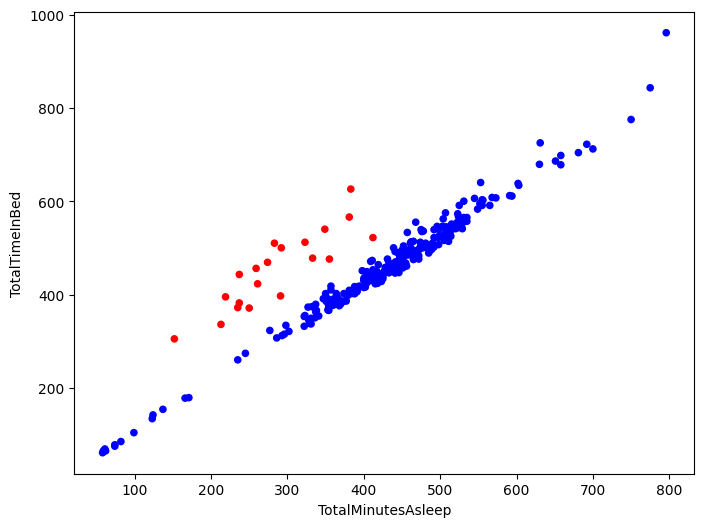

In [60]:
diagnosis_color_map = {"Buono": "blue", "Cattivo": "red"}
X_train.plot.scatter("TotalMinutesAsleep", "TotalTimeInBed", c=y_train.map(diagnosis_color_map), figsize=(8, 6));

In [61]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X2dn_train = scaler.fit_transform(X_train)
X2dn_val = scaler.transform(X_test)

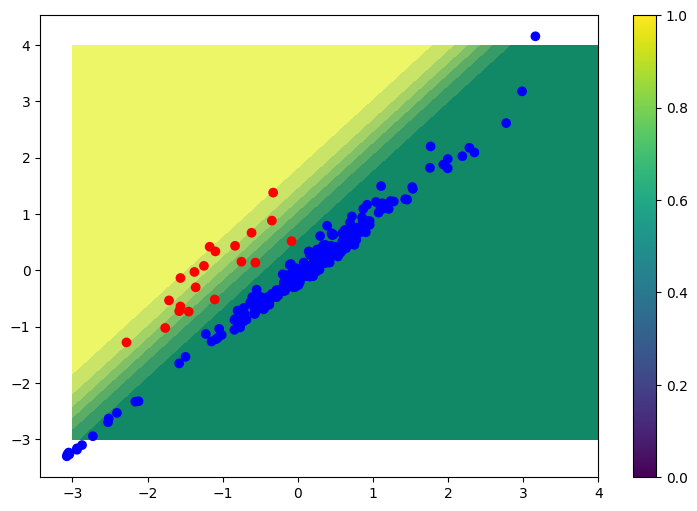

In [62]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(solver="saga", random_state=42)
model.fit(X2dn_train, y_train)
mx1, mx2 = np.meshgrid(np.linspace(-3, 4, 100), np.linspace(-3, 4, 100))
my = model.predict_proba(np.c_[mx1.ravel(), mx2.ravel()])[:, 1].reshape(mx1.shape)
plt.figure(figsize=(9, 6))
plt.contourf(mx1, mx2, my, cmap="summer")
plt.scatter(*X2dn_train.T, c=y_train.map(diagnosis_color_map))
plt.colorbar();

In [63]:
model.score(X2dn_val, y_test)

0.9782608695652174